In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
# External dependencies
import os
import cudf  # cuDF is an implementation of Pandas-like Dataframe on GPU

from sklearn.model_selection import train_test_split

In [3]:
INPUT_DATA_DIR = os.environ.get(
    "INPUT_DATA_DIR", os.path.expanduser("~/nvt-examples/end-to-end-poc/data/")
)

## Splitting into train and validation dataset

In [4]:
# TODO: Sessionize the data here?
# TODO: Change this to a temporal split

In [5]:
ratings = cudf.read_csv(os.path.join(INPUT_DATA_DIR, "ml-25m", "ratings.csv"))
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [6]:
ratings["day"] = ratings["timestamp"] // 86400
min_day = ratings.min()["day"]
ratings["day"] = ratings["day"] - min_day

In [7]:
ratings.head()

,userId,movieId,rating,timestamp,day
0,1,296,5.0,1147880044,4146.0
1,1,306,3.5,1147868817,4146.0
2,1,307,5.0,1147868828,4146.0
3,1,665,5.0,1147878820,4146.0
4,1,899,3.5,1147868510,4146.0


In [8]:
ratings["interaction"] = ratings["rating"] > 3.0

In [9]:
ratings.head()

,userId,movieId,rating,timestamp,day,interaction
0,1,296,5.0,1147880044,4146.0,True
1,1,306,3.5,1147868817,4146.0,True
2,1,307,5.0,1147868828,4146.0,True
3,1,665,5.0,1147878820,4146.0,True
4,1,899,3.5,1147868510,4146.0,True


In [10]:
ratings = ratings.sort_values("timestamp")

In [11]:
ratings.head()

,userId,movieId,rating,timestamp,day,interaction
326761,2262,21,3.0,789652009,0.0,False
326767,2262,47,5.0,789652009,0.0,True
326810,2262,1079,3.0,789652009,0.0,False
2016249,13424,10,3.0,822873600,385.0,False
2016250,13424,11,4.0,822873600,385.0,True


In [52]:
grouped = ratings[ratings["interaction"]].sort_values("timestamp").groupby(
    ["day", "userId"]
).agg({"movieId": "collect"})
grouped = grouped.reset_index()
grouped.head()

,day,userId,movieId
0,0.0,2262,[47]
1,385.0,13424,"[11, 57]"
2,385.0,42937,[32]
3,385.0,102689,"[1, 10, 18, 19, 21, 31, 32, 39, 45, 47, 50, 52..."
4,385.0,109832,"[2, 7, 10, 11, 17, 21, 22, 32, 34, 36, 48, 50,..."


In [54]:
grouped["movieId"]

0                                                       [47]
1                                                   [11, 57]
2                                                       [32]
3          [1, 10, 18, 19, 21, 31, 32, 39, 45, 47, 50, 52...
4          [2, 7, 10, 11, 17, 21, 22, 32, 34, 36, 48, 50,...
                                 ...                        
1129304                     [205156, 205383, 203375, 204698]
1129305                                             [208385]
1129306                                             [192379]
1129307                                             [208737]
1129308                        [111759, 115713, 2105, 73290]
Name: movieId, Length: 1129309, dtype: list

In [42]:
len(grouped)

1129309

In [38]:
grouped.columns

Index(['movieId'], dtype='object')

In [39]:
grouped.reset_index()

,userId,day,movieId
0,1,4146.0,"[5952, 1653, 1250, 6539, 6377, 3448, 1088, 899..."
1,2,4071.0,"[5952, 497, 1374, 1653, 2640, 5445, 151, 236, ..."
2,3,7521.0,"[356, 593, 1270, 1, 2571, 260, 318, 1196, 527,..."
3,3,7688.0,"[1206, 1208, 44191, 32587, 51662, 55820, 40815..."
4,3,8045.0,"[1089, 136449, 4011, 741, 778, 111, 214, 13646..."
...,...,...,...
1129304,162538,7513.0,"[356, 593, 1270, 527, 2324, 2858, 2762, 4993, ..."
1129305,162539,2378.0,"[1721, 480, 1198, 1282, 1784, 608, 3363, 2022,..."
1129306,162540,5315.0,"[3005, 49530, 5400, 54001, 49278, 4167, 4372, ..."
1129307,162540,5317.0,"[69526, 6377, 8961, 4720, 8957, 53953, 37720, ..."


In [13]:
# ratings = ratings.drop("timestamp", axis=1)
train, valid = train_test_split(ratings, test_size=0.2, random_state=42)

In [14]:
train.to_parquet(os.path.join(INPUT_DATA_DIR, "train.parquet"))
valid.to_parquet(os.path.join(INPUT_DATA_DIR, "valid.parquet"))

In [15]:
train.head()

,userId,movieId,rating,timestamp,day,interaction
7627625,49472,80906,2.5,1452818915,7676.0,False
21520859,139909,1207,4.0,1298649177,5891.0,True
23300553,151249,4896,3.5,1201310772,4765.0,True
1654646,11052,2858,4.0,1436986764,7492.0,True
14788558,95754,1077,4.0,1437673270,7500.0,True


## Getting Started

In [16]:
# External dependencies
import os
import cudf  # cuDF is an implementation of Pandas-like Dataframe on GPU

import nvtabular as nvt

In [17]:
INPUT_DATA_DIR = os.environ.get(
    "INPUT_DATA_DIR", os.path.expanduser("~/nvt-examples/end-to-end-poc/data/")
)

In [18]:
movie_genres = cudf.read_parquet(os.path.join(INPUT_DATA_DIR, "movie_genres.parquet"))
movie_genres.head()

,movieId,genres
0,1,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,"[Adventure, Children, Fantasy]"
2,3,"[Comedy, Romance]"
3,4,"[Comedy, Drama, Romance]"
4,5,[Comedy]


In [19]:
movie_tags = cudf.read_parquet(os.path.join(INPUT_DATA_DIR, "movie_tags.parquet"))
movie_tags.head()

,movieId,tags_unique,tags_nunique
0,1,"[2009 reissue in Stereoscopic 3-D, 3D, 55 movi...",126
1,2,"[Adaptation of Book, CLV, Children, Chris Van ...",44
2,3,"[Ann Margaret, Burgess Meredith, CLV, Daryl Ha...",23
3,4,"[CLV, based on novel or book, characters, chic...",8
4,5,"[CLV, Comedy, Diane Keaton, Fantasy, Steve Mar...",20


In [20]:
tags_ds = nvt.Dataset(movie_tags)

In [21]:
CATEGORICAL_COLUMNS = ["tags_unique", "movieId"]
CONTINUOUS_COLUMNS = []
LABEL_COLUMNS = []

In [22]:
cat_with_genres = CATEGORICAL_COLUMNS >> nvt.ops.JoinExternal(movie_genres, on=["movieId"])

In [23]:
cat_features = cat_with_genres >> nvt.ops.Categorify()

In [24]:
cont_features = nvt.ColumnGroup(CONTINUOUS_COLUMNS)

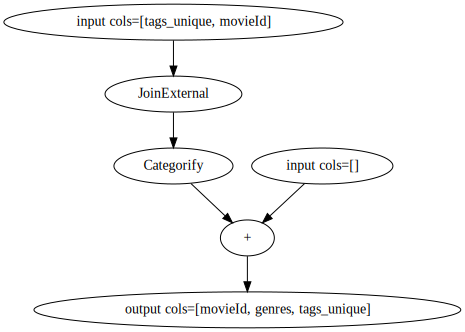

In [25]:
output = cat_features + cont_features
(output).graph

In [26]:
workflow = nvt.Workflow(output)

In [27]:
%%time
workflow.fit(tags_ds)

CPU times: user 364 ms, sys: 20.2 ms, total: 385 ms
Wall time: 384 ms


In [28]:
%time
movie_features = workflow.transform(tags_ds)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 2.62 µs


In [29]:
movie_features_ddf = movie_features.to_ddf()

In [30]:
movie_features_ddf.head()

,movieId,genres,tags_unique
0,1,"[3, 4, 5, 6, 10]","[477, 581, 640, 1857, 2175, 2817, 3538, 4395, ..."
1,2,"[3, 5, 10]","[1206, 4448, 5069, 5213, 7883, 8912, 9116, 925..."
2,3,"[6, 16]","[2196, 4356, 4448, 6484, 11460, 12274, 17647, ..."
3,4,"[6, 9, 16]","[4448, 31525, 34749, 34981, 39134, 48169, 6086..."
4,5,[6],"[4448, 5693, 6977, 8912, 23756, 25354, 28604, ..."


In [31]:
movie_features.to_parquet(os.path.join(INPUT_DATA_DIR, "movie_features.parquet"))